In [21]:
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [13]:
#Image denoising using autoencoder

#adding noise to the cifar-10 train and test data
(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format

noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


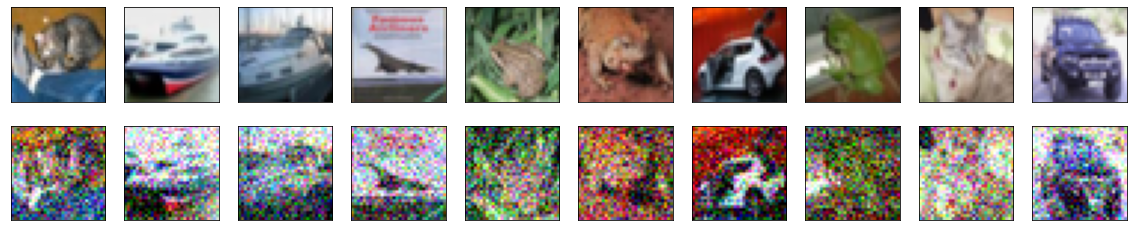

In [14]:
#displaying noisy images using imshow()
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(x_test_noisy[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [15]:
#Encoder model
input_img = Input(shape=(32, 32, 3))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
#Decoder model
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 16)        9232      
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 16)          0   

In [16]:
from keras.callbacks import TensorBoard
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
391/391 [==============================] - 5s 11ms/step - loss: 0.6040 - val_loss: 0.5891
Epoch 2/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5694 - val_loss: 0.5684
Epoch 3/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5665 - val_loss: 0.5678
Epoch 4/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5654 - val_loss: 0.5649
Epoch 5/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5638 - val_loss: 0.5643
Epoch 6/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5631 - val_loss: 0.5635
Epoch 7/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5633 - val_loss: 0.5631
Epoch 8/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5629 - val_loss: 0.5630
Epoch 9/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5619 - val_loss: 0.5638
Epoch 10/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5628 - val_l

In [17]:
#saving model to disk

model_json = autoencoder.to_json()

with open('model_json', 'w') as json_file:
  json_file.write(model_json)
autoencoder.save_weights("model.h5")

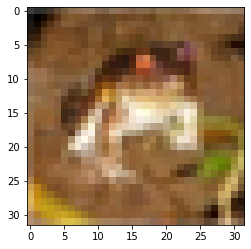

In [18]:
plt.imshow(x_train[0])

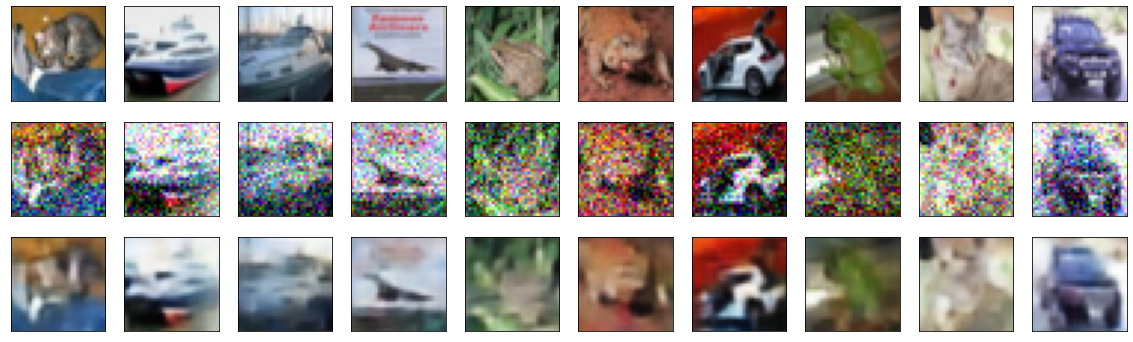

In [19]:
#loading model from json
from keras.models import model_from_json

json_file = open('model_json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('model.h5')

decoded_imgs_noisy = autoencoder.predict(x_test_noisy)
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    #display original image
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display noisey image
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(x_test_noisy[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(decoded_imgs_noisy[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Testing the model against Salt and Pepper Noise

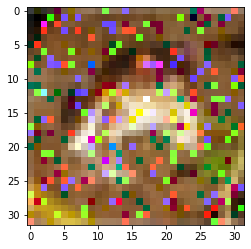

In [24]:
# Add salt-and-pepper noise to the image.
x_train_sp = random_noise(x_train, mode='s&p',amount=0.1)
x_test_sp = random_noise(x_test, mode='s&p',amount=0.1)

x_train_sp = np.clip(x_train_sp, 0., 1.)
x_test_sp = np.clip(x_test_sp, 0., 1.)

plt.imshow(x_train_sp[0])


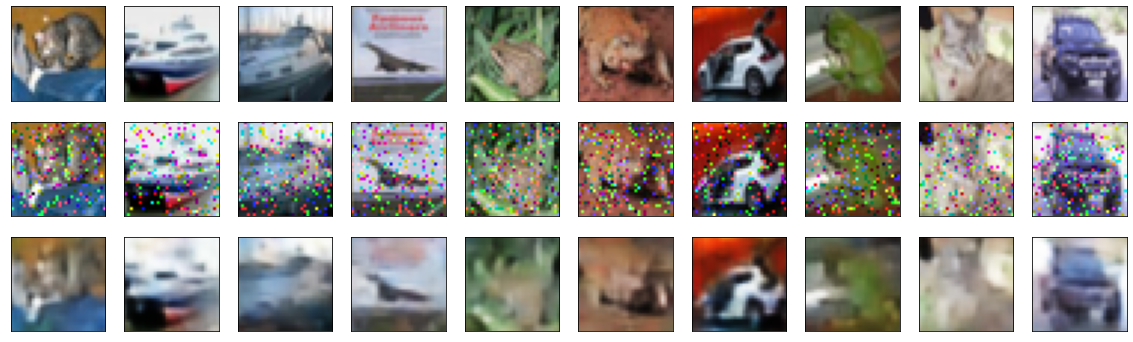

In [23]:
decoded_imgs_noisy_sp = autoencoder.predict(x_test_sp)
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display noisey image
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i+1 + n)
    plt.imshow(x_test_sp[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #display original image
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(decoded_imgs_noisy_sp[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()